  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 80.45it/s]


<Axes: xlabel='dist', ylabel='freq'>

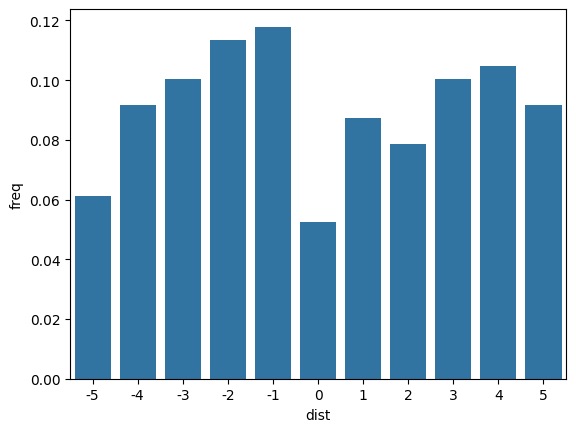

In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from helper_functions import *
import pysam
import pyfaidx
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

path_to_bam_file = "/media/hieunguyen/GSHD_HN01/raw_data/bam_files/WGShg19.bam"
path_to_all_fa = "/media/hieunguyen/GSHD_HN01/storage/resources/hg19"
path_to_bed_file = "./methyl_regions/TSMA_Lung.bed"

read_len = 50
radius = 5
##### fetch reads
bedfile = pd.read_csv(path_to_bed_file, sep="\t", header=None)[[0,1,2,3]]
bedfile.columns = ["chrom", "start", "end", "region"]

readdf = pd.DataFrame()
for region in tqdm(bedfile.region.unique()):
    tmp_readdf = fetch_reads(path_to_bam_file, "chr{}".format(region))
    tmp_readdf["region"] = region
    readdf = pd.concat([readdf, tmp_readdf])

##### fix the type of variable for each column in the dataframe.
readdf["chrom"] = readdf["chrom"].astype(str)
readdf["region"] = readdf["region"].astype(str)
readdf["start"] = readdf["start"].astype(int)
readdf["flen"] = readdf["flen"].astype(int)

##### modify the starting position of the read on reverse strand, negative flen
readdf["start"] = readdf[["start", "flen"]].apply(lambda x: x[0] if x[1] > 0 else x[0] + read_len, axis=1)

##### calculate distance between read and nearest CpG site
readdf["dist_to_nearest_cpg"] = readdf[["chrom", "start"]].apply(lambda x: get_min_dist_to_cpg(x[0], x[1], path_to_all_fa, radius), axis=1)

plotdf = readdf[readdf["dist_to_nearest_cpg"] != "NA"].groupby("dist_to_nearest_cpg")["start"].count().reset_index()
plotdf.columns = ["dist", "count"]
plotdf["freq"] = plotdf["count"] / plotdf["count"].sum()
sns.barplot(data = plotdf, x = "dist", y = "freq")